In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

### Gather Data

In [2]:
df = pd.read_csv('Trades - ML Class 520 before G.csv')
df = df.append(pd.read_csv('Trades - ML Class 520 After G.csv'))
df.shape

(33598, 145)

In [3]:
print(df.entry_time.min(), df.entry_time.max())

2016-04-01 13:36:05.006700 2018-05-16 15:38:05.006700


### Visualize Data ###

In [4]:
### Define Features to Train Model on ###
features = list(df.loc[:,'entry_collect.Bar_mins_five_ago':'entry_collect.upper_limit_price_minus_last_atr'])
features

['entry_collect.Bar_mins_five_ago',
 'entry_collect.Daily_DEMA_Three_Five_Diff',
 'entry_collect.Daily_DEMA_Three_Ten_Diff',
 'entry_collect.Daily_DEMA_Three_Twenty_Diff',
 'entry_collect.Daily_Five_DEMA_from_open',
 'entry_collect.Daily_Ten_DEMA_from_open',
 'entry_collect.Daily_Three_DEMA_from_open',
 'entry_collect.Daily_Twelve_DEMA_from_open',
 'entry_collect.Daily_Twenty_DEMA_from_open',
 'entry_collect.Daily_gap_four_to_five',
 'entry_collect.Daily_gap_prior_to_two',
 'entry_collect.Daily_gap_three_to_four',
 'entry_collect.Daily_gap_two_to_three',
 'entry_collect.Daily_range_five_ago',
 'entry_collect.Daily_range_four_ago',
 'entry_collect.Daily_range_one_ago',
 'entry_collect.Daily_range_three_ago',
 'entry_collect.Daily_range_two_ago',
 'entry_collect.LIR',
 'entry_collect.Location_in_range',
 'entry_collect.New_High_Count',
 'entry_collect.New_Low_Count',
 'entry_collect.Number_of_bars',
 'entry_collect.Over_bought',
 'entry_collect.RVOL',
 'entry_collect.SPY_day_move_vs_ATR'

In [5]:
# Check type of each feature is float
print('Data Types:')
for i in features:
    t = df[i].dtype
    if t != float:
        print(i, t)
        features.remove(i)

Data Types:


In [6]:
# Check for null values 
print('Null Columns:')
for i in features:
    c = df[i].isnull().sum() / float(len(df))
    if c > 0.95:
        print(i, c)
        features.remove(i)

Null Columns:
entry_collect.Location_in_range 1.0


In [7]:
# Check for zero values
print('Zero Columns:')
for i in features:
    n = (df[i] == 0).astype(int).sum() / float(len(df))
    if n > 0.95:
        print(i, n)
        features.remove(i)

Zero Columns:


In [8]:
# Check unique values in each feature
print('Unique Values:')
for i in features:
    u = len(df[i].unique()) / float(len(df))
    if u < 0.1:
        print(i, u)

Unique Values:
entry_collect.New_High_Count 0.013036490267277814
entry_collect.New_Low_Count 0.013929400559557116
entry_collect.Number_of_bars 0.0439907137329603
entry_collect.Over_bought 5.952735281862015e-05
entry_collect.SPY_day_move_vs_ATR 0.06643252574558009
entry_collect.SPY_gap_in_atr 0.01583427584975296
entry_collect.VXX_day_move_vs_ATR 0.06684921721531044
entry_collect.ask_lift_count 0.005893207929043395
entry_collect.count_last_five_bars 0.08705875349723198
entry_collect.mins_above_open 0.01104232394785404
entry_collect.mins_below_open 0.011012560271444729
entry_collect.premarket_bars 0.004940770283945473
entry_collect.st_s_buzz 0.08054050836359307
entry_collect.st_s_dispersion 0.019733317459372582
entry_collect.st_s_mean 0.08488600511935235
entry_collect.st_s_volatility 0.0900946484909816
entry_collect.st_s_volume 0.021489374367521876


### Label Data with Different Classes

In [9]:
### Define Objective and Label ###
df['maxreturn'] = df.mtm_pl
df.maxreturn.describe()

count    33598.000000
mean        -0.948192
std         22.414563
min       -436.240000
25%        -11.480000
50%         -1.300000
75%          8.820000
max        550.240000
Name: maxreturn, dtype: float64

In [10]:
df['label'] = (df.maxreturn > 10).astype(int)

In [11]:
### Look at return details ###
print('Percent of Target Trades:', df.label.sum() / float(len(df)))

Percent of Target Trades: 0.229745818203


### Split Data into Training and Testing Sets

In [17]:
### Split the data into training, testing sets ###
train = df[(pd.to_datetime(df.entry_time) < pd.to_datetime('2018-01-01')) & 
           (pd.to_datetime(df.entry_time) >= pd.to_datetime('2014-01-01'))]
test = df[pd.to_datetime(df.entry_time) >= pd.to_datetime('2018-01-01')]

X_train = train.loc[:,features]
y_train = train.loc[:,'label']

X_test = test.loc[:,features]
y_test = test.loc[:,'label']

print('Length of Training Set: ' + str(len(train)))
print('Length of Testing Set: ' + str(len(test)))

Length of Training Set: 25704
Length of Testing Set: 7894


In [18]:
X_train.shape

(25704, 127)

### Clean and Standardize Data

In [19]:
### Remove null values and replace with the median of each column ###
transform = Imputer(missing_values='NaN',strategy='median')

### Find median of each column in training set and replace null values ###
X_train = transform.fit_transform(X_train)

### Apply median from training set to null values of test set ###
X_test = transform.transform(X_test)

### Train Random Forest

In [ ]:
### Train and fit classifier to Training Data ###
scores = {}

for ne in range(100, 600, 100):
    for md in range(3, 11):
        for mln in range(4, 100, 4):
            clf = RandomForestClassifier(n_estimators=ne, max_depth=md, max_leaf_nodes=mln, n_jobs=-1, verbose=0)

            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            y_pred.sum()

            metric = roc_auc_score(y_test, y_pred)
                
            
            scores[str(ne)+'_'+str(md)+'_'+str(mln)] = metric
            print(metric)

0.5
0.5
0.50082385773
0.500140174959
0.500455788514
0.500595963473
0.500595963473
0.50082385773
0.500368069216
0.500140174959
0.500911577028
0.500595963473
0.500648419134
0.50082385773
0.500508244175
0.500052455661
0.5
0.500227894257
0.499824561404
0.500420524876
0.500648419134
0.5
0.500227894257
0.500368069216
0.5
0.5
0.500964032689
0.500700874794
0.500876313391
0.500560699835
0.500332805578
0.500560699835
0.501191926946
0.500280349918
0.500472980537
0.500420524876
0.500788594092
0.500788594092
0.500472980537
0.500420524876
0.500472980537
0.500788594092
0.500736138432
0.501787890419
0.500700874794
0.499877017064
0.500736138432
0.500052455661
0.5
0.5
0.501104207648
0.500736138432
0.500700874794
0.501296838267
0.500788594092
0.50024508628
0.501612451822
0.500472980537
0.500648419134
0.500560699835
0.500876313391
0.501559996162
0.500297541941
0.501524732524
0.500332805578
0.499964736362
0.500017192023
0.500928769051
0.500420524876
0.500700874794
0.500157366982
0.500700874794
0.5
0.5
0.50

0.5
0.500736138432
0.500595963473
0.50082385773
0.500595963473
0.500140174959
0.500595963473
0.50082385773
0.500736138432
0.500455788514
0.500455788514
0.5
0.500368069216
0.5
0.5
0.50082385773
0.500648419134
0.500736138432
0.500420524876
0.500876313391
0.500420524876
0.500736138432
0.500964032689
0.500648419134
0.500736138432
0.500876313391
0.500560699835
0.500052455661
0.500788594092
0.500560699835
0.500420524876
0.500420524876
0.500648419134
0.500648419134
0.500472980537
0.500560699835
0.500648419134
0.5
0.5
0.500736138432
0.500736138432
0.501419821203
0.500788594092
0.500876313391
0.500648419134
0.500700874794
0.500560699835
0.500876313391
0.500788594092
0.501016488349
0.500876313391
0.500788594092
0.500700874794
0.500876313391
0.500736138432
0.500648419134
0.500928769051
0.501191926946
0.500788594092
0.500560699835
0.501104207648
0.5
0.5
0.50082385773
0.500736138432
0.500876313391
0.501016488349
0.500788594092
0.500700874794
0.501472276864
0.500472980537
0.500665611156
0.5010689440

In [73]:
### Feature Importances ###
importances = sorted(list(zip(clf.feature_importances_, new_features)),reverse=True)
# while len(importances) > 50:
importances = importances[:int(len(importances)*0.9)]
new_features = []
for i, f in importances:
    new_features.append(f)

In [74]:
len(new_features)

64

In [76]:
features = new_features

In [77]:
features

['entry_collect.bar_range_fifteen',
 'entry_collect.VXX_day_move_vs_ATR',
 'entry_collect.day_range_as_ATR',
 'entry_collect.bar_range_thirty',
 'entry_collect.bar_range_sixty',
 'entry_collect.Ticks_Downtick_count',
 'entry_collect.TA_BBwidth',
 'entry_collect.bar_range_five',
 'entry_collect.minsBelowPremarketHigh',
 'entry_collect.Ticks_Uptick_count',
 'entry_collect.SPY_gap_in_atr',
 'entry_collect.mins_below_open',
 'entry_collect.fivebarvwapminsvwapinatr',
 'entry_collect.slope_vwap_from_open',
 'entry_collect.daily_low_minus_last_atr',
 'entry_collect.Ticks_Uptick_Volume',
 'entry_collect.fifteebarvwapminusvwapinatr',
 'entry_collect.last_minus_vwap_in_atr',
 'entry_collect.change_from_open_in_atr',
 'entry_collect.mins_above_open',
 'entry_collect.sixtybarvwapminusvwapinatr',
 'entry_collect.Ticks_Downtick_volume',
 'entry_collect.daily_high_minus_last_atr',
 'entry_collect.RVOL',
 'entry_collect.SPY_day_move_vs_ATR',
 'entry_collect.bar_range_one',
 'entry_collect.minsAbovePre

In [30]:
y_pred = clf.predict(X_test)
y_pred.sum()

12156

In [31]:
trades = test.assign(pred = y_pred)
trades = trades[trades.pred > 0.5]

In [32]:
print('Original Max Return - No ML')
print(test.maxreturn.describe())
print('---------------')
print('Max Return with ML')
print(trades.maxreturn.describe())

Original Max Return - No ML
count    69200.000000
mean         0.309639
std          0.297807
min         -1.654131
25%          0.095233
50%          0.238095
75%          0.444445
max          7.350002
Name: maxreturn, dtype: float64
---------------
Max Return with ML
count    12156.000000
mean         0.435956
std          0.372155
min         -1.654131
25%          0.169492
50%          0.362379
75%          0.627213
max          3.303519
Name: maxreturn, dtype: float64


Original PnL - No ML


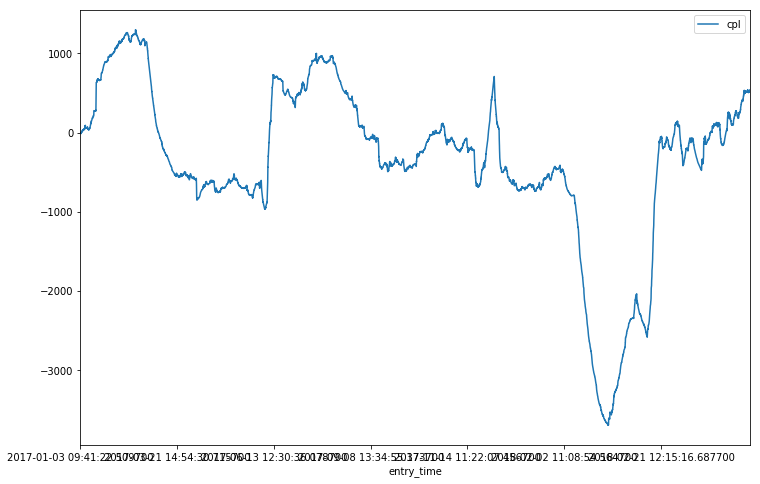

----------------
PnL with ML


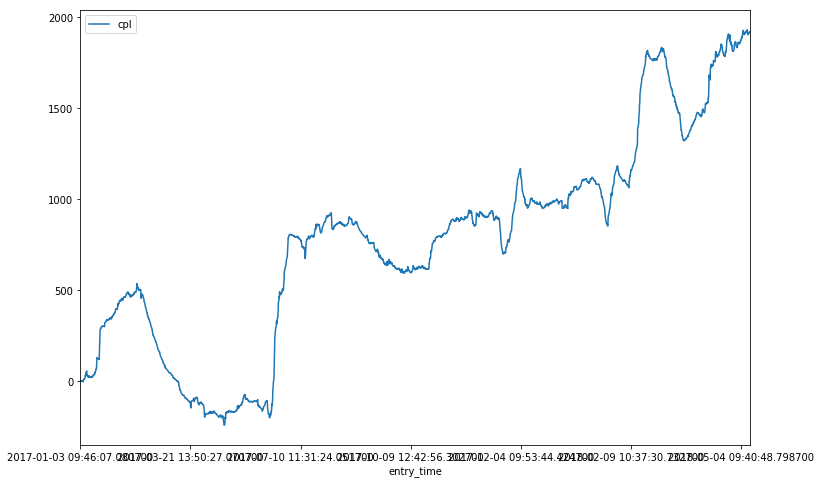

In [33]:
trades = trades.sort_values('entry_time')
trades['cpl'] = trades.mtm_pl.cumsum()
test = test.sort_values('entry_time')
test['cpl'] = test.mtm_pl.cumsum()
print('Original PnL - No ML')
test.plot(x='entry_time',y='cpl',figsize=[12,8])
plt.show()
print('----------------')
print('PnL with ML')
trades.plot(x='entry_time',y='cpl',figsize=[12,8])
plt.show()

In [35]:
### Feature Importances ###
importances = sorted(list(zip(clf.feature_importances_, features)),reverse=True)
# while len(importances) > 50:
importances = importances[:int(len(importances)*0.9)]
for i, f in importances:
    print(f, i)

entry_collect.day_range_as_ATR 0.0443045960221
entry_collect.bar_range_fifteen 0.0416088286834
entry_collect.bar_range_sixty 0.0414432841239
entry_collect.VXX_day_move_vs_ATR 0.0391252663588
entry_collect.bar_range_thirty 0.0345618089665
entry_collect.Ticks_Downtick_count 0.0257313317958
entry_collect.bar_range_five 0.0255946330784
entry_collect.minsBelowPremarketHigh 0.0238952695155
entry_collect.TA_BBwidth 0.0224171010543
entry_collect.Ticks_Uptick_count 0.0223256646349
entry_collect.mins_below_open 0.0194838574712
entry_collect.slope_vwap_from_open 0.0193783256754
entry_collect.change_from_open_in_atr 0.0184822731666
entry_collect.fivebarvwapminsvwapinatr 0.0184798649429
entry_collect.bar_range_one 0.0166827495633
entry_collect.SPY_gap_in_atr 0.0166796959894
entry_collect.last_minus_vwap_in_atr 0.0164792302881
entry_collect.Ticks_Downtick_volume 0.0158620440139
entry_collect.fifteebarvwapminusvwapinatr 0.0154475936488
entry_collect.daily_low_minus_last_atr 0.0153874143683
entry_coll

In [33]:
len(features)

127

## Gradient Boosted Model

In [106]:
data = lgb.Dataset(X_train, y_train)
param = {'max_depth':6, 'num_leaves':10, 'learning_rate':0.01, 'num_threads':-1,
         'min_data_in_leaf':100, 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
bst = lgb.train(param, data, 500)

In [107]:
y_pred = bst.predict(X_test)
y_pred.sum()

18057.297662074401